In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pylab as plt
import copy
import json
from scipy.interpolate import splprep, splev

In [2]:
is_colab=True
if not is_colab:
    save_dir="./data_files"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    save_dir="/content/drive/MyDrive/Colab Notebooks/16natcomm/"


Mounted at /content/drive


In [3]:
def create_cursive_curve(points, n_points=50):
    """Interpolate a smooth curve through given control points."""
    points = np.array(points)
    tck, u = splprep([points[:,0], points[:,1]], s=0, per=False)
    u_fine = np.linspace(0, 1, n_points)
    x_fine, y_fine = splev(u_fine, tck)
    # Stack into (T, 2) array, normalize
    curve = np.stack([x_fine, y_fine], axis=-1)
    curve -= curve.min(axis=0)
    curve /= curve.max(axis=0)
    return curve

In [4]:
def gen_cos(T,Nin,ipt_str,device):
  # ターゲット出力 (cos, sin)
  t = torch.arange(T, dtype=torch.float32).to(device)
  target = torch.stack([0.5*torch.cos(2 * np.pi * t / 50)+0.5], dim=1)

  # ランダムな ±1 定数入力
  x_input = ipt_str*torch.from_numpy(np.random.choice([-1, 1], size=(1, Nin)).astype(np.float32)).to(device)
  x_input = x_input.repeat(T, 1)  # shape: (T, Nin)

  return x_input,target

def gen_genchar(T,Nin,ipt_str,batch_size,device):
  # ターゲット出力 F,L,R in the cursive style
  # Control points for each letter in a rough cursive style
  # Cursive "F"
  F_points = [
      [0.0, 1.0],    # start top left hook
      [0.1, 1.05], [0.3, 1.05], [0.6, 0.95],  # top horizontal line
      [0.55, 0.9], [0.4, 0.75],  # slight downward curve for cross stroke
      #[0.3, 0.7], [0.35, 0.6],  # vertical stroke starts
      [0.35, 0.5], [0.3, 0.3], [0.25, 0.15], # descending straight line
      [0.1, 0.1], [0.2, 0.5], [0.3, 0.6], [0.5, 0.65], [0.6, 0.65]  # bottom loop swirl
  ]

  # Cursive "L"
  L_points = [
      [0,0.9], [0.1,0.1], [0.4,0.1], [0.6,0.15], [0.8,0.3], [0.7,0.5]
  ]

  # Cursive "R"
  R_points = [
      [0,1],[0,0], [0.0,1], [0.3,1], [0.5,0.7], [0.3,0.5], [-0.1,0.5],[0.1,0.4], [0.6,0], [0.8,0.3]
  ]

  # Generate curves
  curve_F = create_cursive_curve(F_points)
  curve_L = create_cursive_curve(L_points)
  curve_R = create_cursive_curve(R_points)

  # targets: T×batch_size×Nout
  # 1) Convert targets to a single torch tensor of shape (T, batch_size, Nout)
  targets = np.stack([curve_F, curve_L,curve_R], axis=1)       # shape: (T, 3, 2)
  targets = torch.from_numpy(targets).float() # convert to float Tensor

  # Prepare batched data with binary ±1 inputs:
  static_inputs = ipt_str*(torch.randint(0, 2, (batch_size, Nin)).float() * 2 - 1)
  x_input = static_inputs.unsqueeze(0).repeat(T, 1, 1)  # x: (T, batch_size, Nin)

  return x_input,targets

class CustomRNN(nn.Module):
    def __init__(self, Nin: int, Nhid: int, Nout: int = 2):
        super().__init__()
        self.W_in = nn.Parameter(torch.randn(Nhid, Nin) * 0.1, requires_grad=False)
        self.W_hh = nn.Parameter(torch.randn(Nhid, Nhid) * 0.1)
        self.W_out = nn.Parameter(torch.randn(Nout, Nhid) * 0.1, requires_grad=False)

        nn.init.orthogonal_(self.W_hh)
        nn.init.xavier_uniform_(self.W_in)
        nn.init.xavier_uniform_(self.W_out)

    def forward(self, x: torch.Tensor, noise_std: float = 0.0, record_states: bool = False):
        """
        x: (T, batch, Nin)
        noise_std: standard deviation of noise to add at each step (0.0 for no noise)
        record_states: if True, returns full hidden-state sequence
        """
        is_batch = True
        if x.dim() == 2:
            is_batch = False
            x = x.unsqueeze(1)  # (T, batch, Nin)
        T, batch, _ = x.shape
        # initialize hidden state with small noise
        h = torch.randn(batch, self.W_hh.size(0), device=x.device) * 0.05

        outputs = []
        states = []
        for t in range(T):
            preact = h @ self.W_hh.t() + x[t] @ self.W_in.t()
            h = torch.tanh(preact)
            if noise_std > 0.0:
                h = h + torch.randn_like(h) * noise_std
            outputs.append(h @ self.W_out.t())
            if record_states:
                states.append(h)

        y = torch.stack(outputs, dim=0)
        if not is_batch:
            y = y.squeeze(1)

        if record_states:
            hs = torch.stack(states, dim=0)  # (T, batch, Nhid)
            if not is_batch:
                hs = hs.squeeze(1)
            return y, hs
        return y, h


In [5]:
def eval_with_W_hh(model, xin, target, W_hh_param=None):
    # Store current weights
    W_hh_backup = model.W_hh.data.clone()

    try:
        if W_hh_param is not None:
            with torch.no_grad():
                model.W_hh.data = W_hh_param.to(model.W_hh.device)
        with torch.no_grad():
            output, h = model(xin,record_states=True)
            loss = loss_fn(output, target)
    finally:
        # Restore original weights, no matter what (even if exception)
        with torch.no_grad():
            model.W_hh.data = W_hh_backup
    return np.copy(output.detach().cpu().numpy()),np.copy(h.detach().cpu().numpy())

def gen_sim_FLR1(model,xin,target,W_hh_before,W_hh_epoch0):
    ##  calc the empirical speeds
    if xin.dim() == 2:
      xin = xin.unsqueeze(1)  # (T, batch, Nin)
      target=target.unsqueeze(1)
    batch_size=xin.shape[1]
    T=xin.shape[0]

    _,h_before = eval_with_W_hh(model,xin,target,W_hh_before)
    _,h_0 = eval_with_W_hh(model,xin,target,W_hh_epoch0)
    dltx_emp=np.mean(h_0[-50:],axis=0)-np.mean(h_before[-50:],axis=0)


    ## calc covariance under input
    noise_std = 0.01  # ノイズの標準偏差
    repeat = 10  # repeat of trials
    multiT = 100 # extend the simulation time
    _, h_noisy = run_with_noise(model,xin.repeat(multiT, 1,1),W_hh_before, noise_std=noise_std, repeat=repeat)
    cov_ipt = [np.mean(np.array([np.cov(h_noisy[i][10:,k].T) for i in range(repeat)]),axis=0) for k in range(batch_size)]


    # Convert all tensors to numpy arrays at the start
    Win = model.W_in.detach().cpu().numpy()
    W_hh0 = W_hh_epoch0.detach().cpu().numpy()
    W_hh_b = W_hh_before.detach().cpu().numpy()
    xin_np = xin.detach().cpu().numpy()

    # Compute delta W
    dltW = W_hh0 - W_hh_b

    # xr: mean of last 50 h_before, axis 0, column vector shape
    xr = np.mean(h_before[-50:], axis=0)  # (batch,Nhid)

    # Precompute Win@xin[0]
    Win_xin = xin_np[0] @ Win.T

    # Argument for the cosh
    arg = xr @W_hh_b.T + Win_xin  # batch,Nhid
    sech2 = 1.0 / np.cosh(arg)**2
    B= [np.diag(sech2[i]) for i in range(batch_size)]


    # dltx_th: main computation, fully numpy
    dltx_th = [  ((2.0 / noise_std**2) * cov_ipt[i] @ B[i] @ dltW @ xr[i:i+1].T) for i in range(batch_size)]
    dltx_th = np.array(dltx_th)

    print(dltx_emp.shape,dltx_th.shape,cov_ipt[0].shape,B[0].shape,dltW[0].shape,xr[0].shape)
    # Cosine similarity
    x = dltx_emp
    y = dltx_th
    sim = [np.dot(x[i], y[i]) / (np.linalg.norm(x[i]) * np.linalg.norm(y[i])) for i in range(batch_size)]

    # Variance
    var = [xr[i][None,:] @ cov_ipt[i] @ xr[i][:,None]/np.sum(xr[i]**2) for i in range(batch_size)]

    return sim, dltx_emp, dltx_th, var,[np.diag(B[i]) for i in range(batch_size)]

def run_with_noise(model: nn.Module, xin: torch.Tensor,
                   W_hh_param: torch.Tensor = None, noise_std: float = 0.1, repeat: int = 1):
    """
    Runs the RNN model multiple times with optional noise and returns outputs and hidden states.

    Returns:
      all_outputs: np.ndarray of shape (repeat, T, batch, Nout)
      all_states:  np.ndarray of shape (repeat, T, batch, Nhid)
    """
    # prepare a model copy for evaluation
    model_eval = copy.deepcopy(model).to(device)
    if W_hh_param is not None:
        model_eval.W_hh.data = W_hh_param.to(device)

    all_outputs = []
    all_states = []
    with torch.no_grad():
        for _ in range(repeat):
            y, hs = model_eval(xin.to(device), noise_std=noise_std, record_states=True)
            all_outputs.append(y.cpu().numpy())
            all_states.append(hs.cpu().numpy())

    return np.stack(all_outputs), np.stack(all_states)

def save_model_to_json(model, W_hh_before,W_hh_epoch0, hyperparams, x_input, target,hist,fname):
    data = {}

    # Parameters as lists
    data['W_in'] = model.W_in.detach().cpu().numpy().tolist()
    data['W_hh'] = model.W_hh.detach().cpu().numpy().tolist()
    data['W_out'] = model.W_out.detach().cpu().numpy().tolist()
    data["W_hh_before"] = W_hh_before.detach().cpu().numpy().tolist()
    data["W_hh_epoch0"] = W_hh_epoch0.detach().cpu().numpy().tolist()

    # Model hyperparameters
    data['hyperparams'] = hyperparams

    # history of epochs
    data["hist"]=hist

    # Input and target as lists
    data['x_input'] = x_input.detach().cpu().numpy().tolist()
    data['target'] = target.detach().cpu().numpy().tolist()


    # Save to JSON
    filepath=save_dir+fname
    with open(filepath, 'w') as f:
        json.dump(data, f)

def load_model_from_json(fname):
    filepath=save_dir+fname
    with open(filepath, 'r') as f:
        data = json.load(f)

    hp = data['hyperparams']
    model = CustomRNN(hp['Nin'], hp['Nhid'], hp['Nout'])
    model.W_in.data = torch.tensor(data['W_in'])
    model.W_hh.data = torch.tensor(data['W_hh'])
    model.W_out.data = torch.tensor(data['W_out'])
    W_hh_before = torch.tensor(data['W_hh_before'])
    W_hh_epoch0 = torch.tensor(data['W_hh_epoch0'])
    hist= data["hist"]

    # Recover x_input and target as tensors
    x_input = torch.tensor(data['x_input'])
    target = torch.tensor(data['target'])
    return model, x_input, target, W_hh_before, W_hh_epoch0, hist

In [16]:
type_task="cos"  # cos or genchar

### training phase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss()

# set task specific variables and parameters
if type_task=="cos":
  Nin, Nhid, Nout = 10, 500, 1
  T = 100
  thrs=0.02
elif type_task=="genchar":
  Nin, Nhid, Nout = 10, 500, 2
  T = 50
  thrs=0.01
  batch_size = 3   # <-- now 3 streams in a single batch
else:
  print("invalid task flg !!!!")



cos task: ipt=0.2, W0=0.7はうまくいく。W0=1.1はうまくいく場合といかない場合がある
genchar: ipt=0.2, W0=0.7,0.8はちょいちょいうまくいかない場合がある。


In [ ]:
Nnet=10

list_ipt=[0.2]
list_W0=[0.7,0.8]

for ipt_str in list_ipt:
  for W0 in list_W0:
    hyperparams = {      'Nin': Nin,      'Nhid': Nhid,      'Nout': Nout    }

    for inet in range(Nnet):
      if type_task=="cos":
        x_input,target=gen_cos(T,Nin,ipt_str,device)
      elif type_task=="genchar":
        x_input,target=gen_genchar(T,Nin,ipt_str,batch_size,device)


      # モデル初期化
      model = CustomRNN(Nin, Nhid, Nout).to(device)
      model.W_hh.data = model.W_hh.data*W0

      # 初期パラメタ保存
      W_hh_before = model.W_hh.detach().cpu().clone()

      # 最適化対象は W_hh のみ
      if type_task=="cos":
        optimizer = optim.SGD([model.W_hh], lr=0.01,momentum=0.1)
      elif type_task=="genchar":
        optimizer = optim.Adam([model.W_hh], lr=0.001)

      loss_fn = nn.MSELoss()

      # 学習ループ
      epochs = 10000
      hist=[]
      for epoch in range(epochs):
          optimizer.zero_grad()
          output, _ = model(x_input)
          loss = loss_fn(output, target)
          loss.backward()
          optimizer.step()

          hist.append(loss.item())
          # epoch 0 終了時のパラメタを保存
          if epoch == 0:
              W_hh_epoch0 = model.W_hh.detach().cpu().clone()

          if loss.item()<thrs:
              print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
              break

          if epoch % 100 == 0:
              print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

      # ====== 学習終了後のパラメタ保存 ======
      W_hh_final = model.W_hh.detach().cpu().clone()

      save_model_to_json(model,W_hh_before,W_hh_epoch0,hyperparams, x_input, target, hist,'%s_rnn%d_%g_%g_all_params.json'%(type_task,inet,W0,ipt_str))



Epoch 0: Loss = 0.2972
Epoch 100: Loss = 0.1026
Epoch 200: Loss = 0.0790
Epoch 300: Loss = 0.0936
Epoch 400: Loss = 0.0772
Epoch 500: Loss = 0.0832
Epoch 600: Loss = 0.1217
Epoch 700: Loss = 0.4360
Epoch 800: Loss = 0.1408
Epoch 900: Loss = 0.0995
Epoch 1000: Loss = 0.1022
Epoch 1100: Loss = 0.0945
Epoch 1200: Loss = 0.0761
Epoch 1300: Loss = 0.0725
Epoch 1400: Loss = 0.0680
Epoch 1500: Loss = 0.0634
Epoch 1600: Loss = 0.0503
Epoch 1700: Loss = 0.0499
Epoch 1800: Loss = 0.0524
Epoch 1900: Loss = 0.0315
Epoch 2000: Loss = 0.0250
Epoch 2100: Loss = 0.0253
Epoch 2200: Loss = 0.0239
Epoch 2300: Loss = 0.0248
Epoch 2400: Loss = 0.0224
Epoch 2500: Loss = 0.0184
Epoch 2600: Loss = 0.0177
Epoch 2700: Loss = 0.0192
Epoch 2800: Loss = 0.0174
Epoch 2900: Loss = 0.0229
Epoch 3000: Loss = 0.0187
Epoch 3100: Loss = 0.0157
Epoch 3200: Loss = 0.0156
Epoch 3300: Loss = 0.0206
Epoch 3400: Loss = 0.0472
Epoch 3500: Loss = 0.0254
Epoch 3600: Loss = 0.0173
Epoch 3700: Loss = 0.0182
Epoch 3800: Loss = 0.016

#  gen char task

## recall behaviors

In [ ]:
model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('genchar_rnn%d_1.05_%g_all_params.json'%(1,1))
output,h=eval_with_W_hh(model,x_input,target)
output0,h0=eval_with_W_hh(model,x_input,target,W_hh_param=W_hh_before)
output1,h1=eval_with_W_hh(model,x_input,target,W_hh_param=W_hh_epoch0)

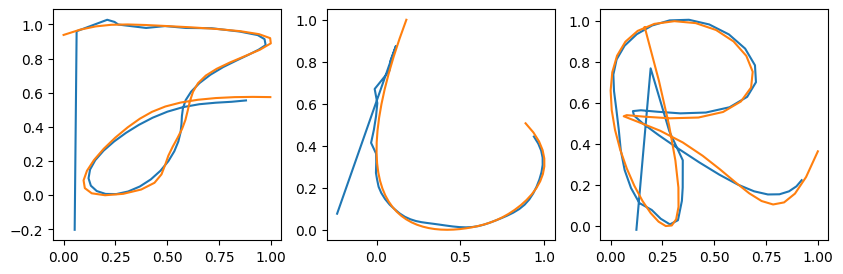

In [ ]:
plt.figure(figsize=(10,3))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.plot(output[:,i,0],output[:,i,1])
  plt.plot(target[:,i,0],target[:,i,1])
plt.savefig(save_dir+"target_FLR.pdf")

(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
[array([0.77312101]), array([0.76574361]), array([0.7714249])]


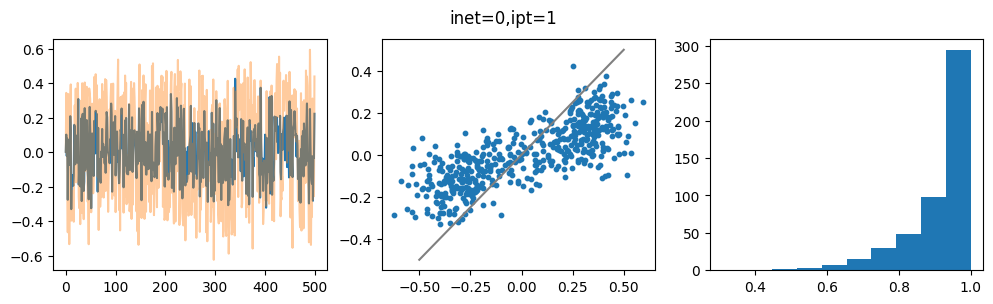

In [ ]:
model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('genchar_rnn%d_0.85_%g_all_params.json'%(2,1))
tmp=gen_sim_FLR1(model,x_input,target,W_hh_before,W_hh_epoch0)
ipat=1
print(tmp[0])
plt.figure(figsize=(12,3))
plt.suptitle("inet=0,ipt=1")
plt.subplot(1,3,1)
plt.plot(tmp[1][ipat])
plt.plot(tmp[2][ipat],alpha=0.4)

plt.subplot(1,3,2)
plt.scatter(tmp[2][ipat],tmp[1][ipat],s=10)
x=np.linspace(-0.5,0.5,5)
plt.plot(x,x,c="gray")
plt.subplot(1,3,3)
plt.hist(tmp[4][ipat])
plt.savefig(save_dir+"comp_genchar.eps")

In [13]:
# parameter for genearation of data
list_ipt=[0.2,0.4,0.6,0.8,1]
list_W0=[0.85,0.9,0.95,1.0,1.05]

In [ ]:
## data generation
var_FLR1_all=[]

for ipt_str in list_ipt:
  for inet in range(10):
    model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('genchar_rnn%d_0.85_%g_all_params.json'%(inet,ipt_str))
    tmp=gen_sim_FLR1(model,x_input,target,W_hh_before,W_hh_epoch0)
    var_FLR1_all.append(tmp[:])

for W0 in list_W0:
  for inet in range(10):
    model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('genchar_rnn%d_%g_0.2_all_params.json'%(inet,W0))
    tmp=gen_sim_FLR1(model,x_input,target,W_hh_before,W_hh_epoch0)
    var_FLR1_all.append(tmp[:])
lst_serializable = [arr.tolist() if isinstance(arr, np.ndarray) else arr for i in var_FLR1_all for var1 in i for arr in var1 ]
filepath=save_dir+"genchar_FLR1_data"

with open(filepath, 'w') as f:
    json.dump(lst_serializable, f)

(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500) (500, 500) (500,) (500,)
(3, 500) (3, 500, 1) (500, 500)

In [12]:
# load
filepath=save_dir+"genchar_FLR1_data"
with open(filepath, 'r') as f:
    loaded = json.load(f)
var_FLR1_all=[ [loaded[15*k:15*k+3],np.array(loaded[15*k+3:15*k+6]),np.array(loaded[15*k+6:15*k+9])]  for k in range(100)]


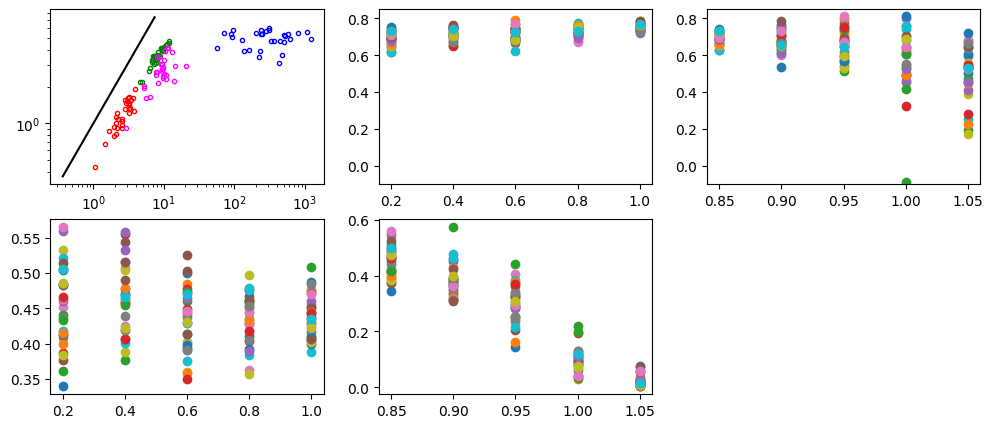

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(2,3,1)
tmp=var_FLR1_all[:10]
for inet in range(10):
  for i in range(3):
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="r",label="ipt=0.2 W0=0.85")
tmp=var_FLR1_all[40:50]
for inet in range(10):
  for i in range(3):
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="g",label="ipt=1 W0=0.85")

tmp=var_FLR1_all[70:80]
for inet in range(10):
  for i in range(3):
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="magenta",label="ipt=0.2 W0=1.05")

tmp=var_FLR1_all[90:100]
for inet in range(10):
  for i in range(3):
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="b",label="ipt=0.2 W0=1.05")

x=np.exp(np.linspace(-1,2,5))
plt.plot(x,x,c="k")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2,3,2)
for i in range(5):
  tmp=var_FLR1_all[10*i:10*(i+1)]
  for inet in range(10):
    for k in range(3):
      plt.scatter(list_ipt[i],tmp[inet][0][k])
plt.ylim(-0.1,0.85)

plt.subplot(2,3,3)
for i in range(5):
  tmp=var_FLR1_all[50+10*i:50+10*(i+1)]
  for inet in range(10):
    for k in range(3):
      plt.scatter(list_W0[i],tmp[inet][0][k])
plt.ylim(-0.1,0.85)


plt.subplot(2,3,4)
for i in range(5):
  tmp=var_FLR1_all[10*i:10*(i+1)]
  for inet in range(10):
    for k in range(3):
      plt.scatter(list_ipt[i],np.sqrt(np.sum(tmp[inet][1][k]**2))/np.sqrt(np.sum(tmp[inet][2][k]**2)))

plt.subplot(2,3,5)
for i in range(5):
  tmp=var_FLR1_all[50+10*i:50+10*(i+1)]
  for inet in range(10):
    for k in range(3):
      plt.scatter(list_W0[i],np.sqrt(np.sum(tmp[inet][1][k]**2))/np.sqrt(np.sum(tmp[inet][2][k]**2)))

plt.savefig(save_dir+"comp_genchar_spd.eps")

In [ ]:
hist_all=[[],[],[]]
for inet in range(10):
  model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('genchar_rnn%d_1.05_%g_all_params.json'%(inet,0.2))
  hist_all[0].append(hist)

for inet in range(10):
  model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('genchar_rnn%d_0.85_%g_all_params.json'%(inet,0.2))
  hist_all[1].append(hist)

for inet in range(10):
  model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('genchar_rnn%d_0.85_%g_all_params.json'%(inet,1))
  hist_all[2].append(hist)


0.5762901544570923 -0.1344433084130287 1.5596100494265557


(0.0, 50.0)

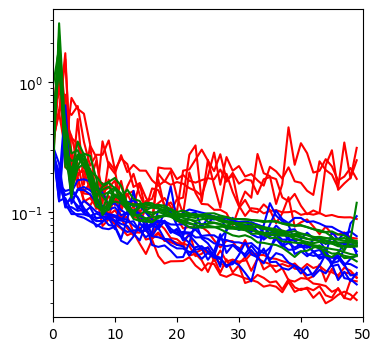

In [ ]:
tmp,tmp1,tmp2=[i[1]-i[0] for i in hist_all[0]],[i[1]-i[0] for i in hist_all[1]],[i[1]-i[0] for i in hist_all[2]]
print(np.mean(tmp),np.mean(tmp1),np.mean(tmp2))
plt.figure(figsize=(4,4))
for inet in range(10):
  plt.plot(hist_all[0][inet][:50],c="r")
for inet in range(10):
  plt.plot(hist_all[1][inet][:50],c="b")
for inet in range(10):
  plt.plot(hist_all[2][inet][:50],c="g")
plt.yscale("log")
plt.xlim(0,50)


In [ ]:
model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('genchar_rnn%d_1.05_%g_all_params.json'%(0,0.2))

### relation between total learning epoch and delta x_th
相関はなさそう

(0.0, 50.0)

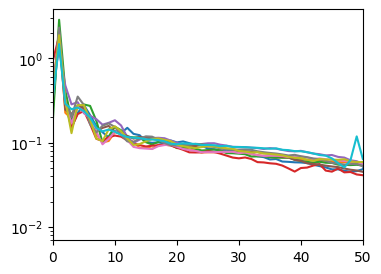

In [ ]:
plt.figure(figsize=(4,3))
for inet in range(10):
  model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('genchar_rnn%d_0.85_%g_all_params.json'%(inet,1))
  plt.plot(hist)
plt.yscale("log")
plt.xlim(0,50)

In [ ]:
epoch_all=[]
for inet in range(10):
  model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('genchar_rnn%d_0.85_%g_all_params.json'%(inet,1))
  hist=np.array(hist)
  idx = np.where(hist < 0.1)[0]
  epoch_all.append([idx[0],len(hist)])
epoch_all=np.array(epoch_all)

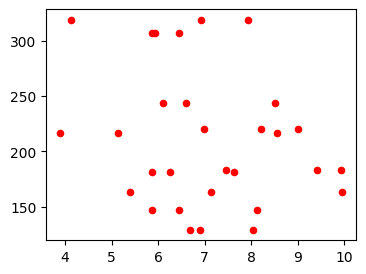

In [ ]:
plt.figure(figsize=(4,3))
tmp=var_FLR1_all[10:20]
for inet in range(10):
  for i in range(3):
    plt.scatter(np.sqrt(np.sum(tmp[inet][2][i]**2)),epoch_all[inet][1],s=20,c="r",label="ipt=0.2 W0=1")

#  cos task

2025/6/8 N=500, lr=0.1 mom=0.1 in SGDだとlossがかなり振動して収束しない。
そこでlr=0.01にすると問題なく500epoch前後で収束した。

6/9 なぜかbeta=0.8付近のときしかうまくいかない。なんかのバグとかではなさそう。できるだけひろい領域で学習できるようにしたいが。。。
lr=0.02,momentum=0.3 にするとすこし広い領域で学習が成功する。ただしbeta=0.8が圧倒的に早い　またカオス領域ではうまくいかない

6/11
Wの初期化をorthogonal, xavierにするとbeta＝１でめちゃ収束がはやくなった。

6/12
単純にvar (xr方向の)と|delta x|は全然関係がない。



### recall behaviors

In [ ]:
model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('rnn1_0.85_0.2_all_params.json')

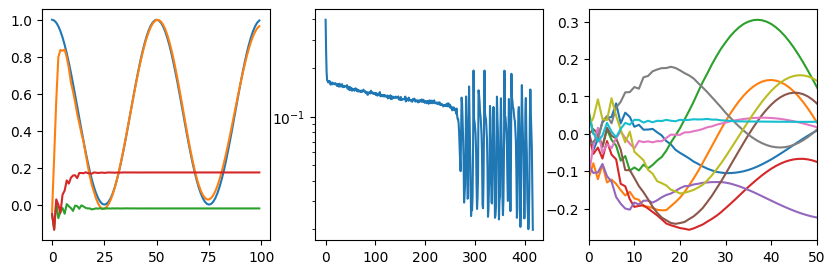

In [ ]:
model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('rnn1_0.85_0.2_all_params.json')
# plot the output after learning terminated
output,h=eval_with_W_hh(model,x_input,target)
output0,h0=eval_with_W_hh(model,x_input,target,W_hh_param=W_hh_before)
output1,h1=eval_with_W_hh(model,x_input,target,W_hh_param=W_hh_epoch0)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.plot(target[:,0])
plt.plot(output[:,0])
plt.plot(output0[:,0])
plt.plot(output1[:,0])
plt.subplot(1,3,2)
plt.plot(hist)
plt.yscale("log")
plt.subplot(1,3,3)
plt.plot(h[:,:200:20])
plt.xlim(0,50)

plt.savefig(save_dir+"FLR1_recall.eps")

(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)


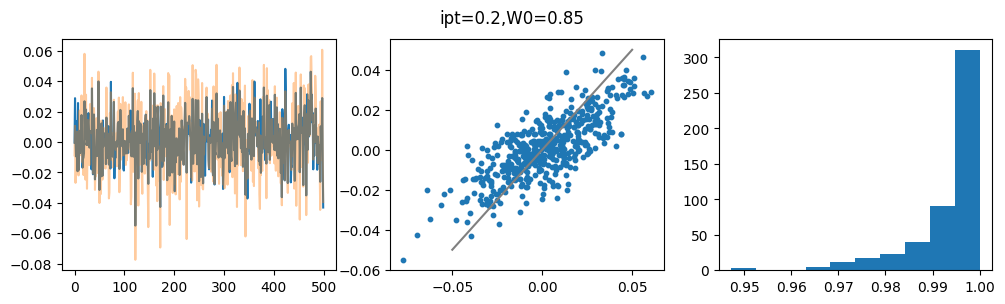

In [ ]:
# theoretical state change vs the measured one.
model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('rnn1_0.85_0.2_all_params.json')
tmp=gen_sim_FLR1(model,x_input,target,W_hh_before,W_hh_epoch0)

plt.figure(figsize=(12,3))
plt.suptitle("ipt=0.2,W0=0.85")
plt.subplot(1,3,1)
plt.plot(tmp[1][0])
plt.plot(tmp[2][0],alpha=0.4)
plt.subplot(1,3,2)
plt.scatter(tmp[2][0],tmp[1][0],s=10)
x=np.linspace(-0.05,0.05,5)
plt.plot(x,x,c="gray")
plt.subplot(1,3,3)
plt.hist(tmp[4][0])
plt.savefig(save_dir+"FLR1_comp_085_02.eps")

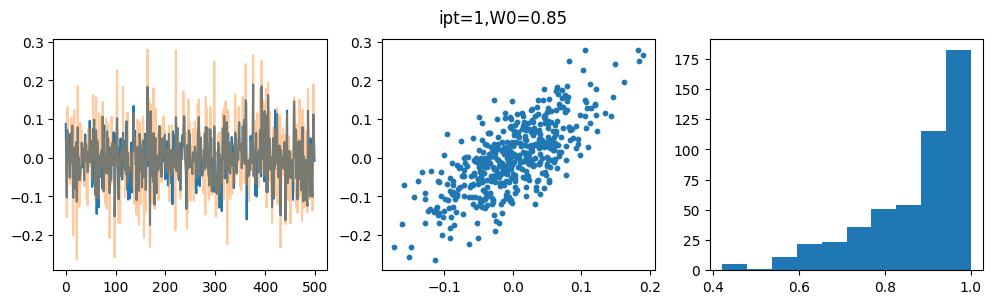

In [ ]:
#model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('rnn1_0.85_1_all_params.json')
#tmp=gen_sim_FLR1(model,x_input,target,W_hh_before,W_hh_epoch0)

plt.figure(figsize=(12,3))
plt.suptitle("ipt=1,W0=0.85")
plt.subplot(1,3,1)
plt.plot(tmp[1])
plt.plot(tmp[2],alpha=0.4)
plt.subplot(1,3,2)
plt.scatter(tmp[1],tmp[2],s=10)
plt.subplot(1,3,3)
plt.hist(tmp[4])
plt.savefig(save_dir+"FLR1_comp_085_1.eps")

In [17]:
list_ipt=[0.2,0.4,0.6,0.8,1.0]
list_W0=[0.85,0.9,0.95,1,1.05]

In [40]:
### generating data
var_FLR1_all=[]
for ipt_str in list_ipt:
  for inet in range(10):
    model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('rnn%d_0.85_%g_all_params.json'%(inet,ipt_str))
    tmp=gen_sim_FLR1(model,x_input,target,W_hh_before,W_hh_epoch0)
    var_FLR1_all.append(tmp[:])

for W0 in list_W0:
  for inet in range(10):
    model, x_input, target,W_hh_before,W_hh_epoch0, hist = load_model_from_json('rnn%d_%g_0.2_all_params.json'%(inet,W0))
    tmp=gen_sim_FLR1(model,x_input,target,W_hh_before,W_hh_epoch0)
    var_FLR1_all.append(tmp[:])

lst_serializable = [arr.tolist() if isinstance(arr, np.ndarray) else arr for i in var_FLR1_all for var1 in i for arr in var1 ]

filepath=save_dir+"cos_FLR1_data"
with open(filepath, 'w') as f:
    json.dump(lst_serializable, f)

(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500) (500, 500) (500,) (500,)
(1, 500) (1, 500, 1) (500, 500)

In [62]:
var_FLR1_all=[ [loaded[5*k],np.array(loaded[5*k+1]),np.array(loaded[5*k+2]),loaded[5*k+3],np.array(loaded[5*k+4])]  for k in range(100)]

In [67]:
#vartmptmp=copy.deepcopy(var_FLR1_all)
var_FLR1_all=copy.deepcopy(vartmptmp)

In [56]:
filepath=save_dir+"cos_FLR1_data"
with open(filepath, 'r') as f:
    loaded = json.load(f)

In [65]:
loaded

IndexError: list index out of range

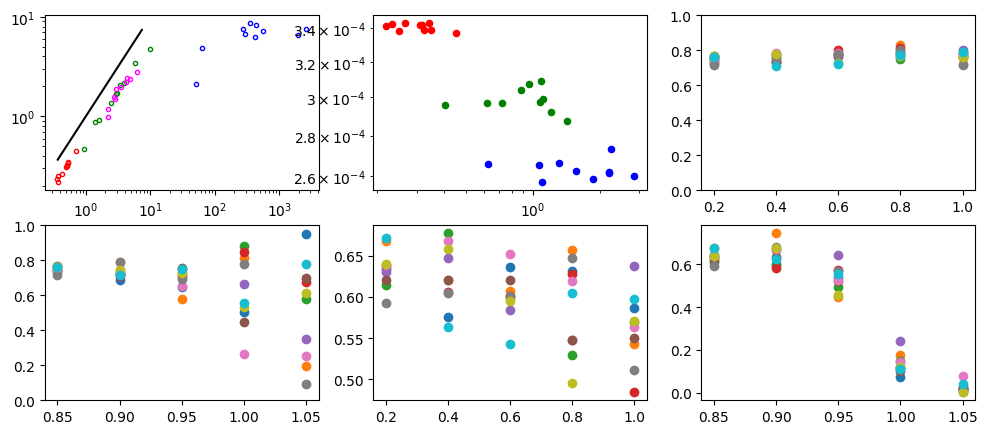

In [69]:
plt.figure(figsize=(12,5))

plt.subplot(2,3,1)
tmp=var_FLR1_all[:10]
for inet in range(10):
    i=0
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="r",label="ipt=0.2 W0=0.85")

tmp=var_FLR1_all[40:50]
for inet in range(10):
    i=0
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="g",label="ipt=1 W0=0.85")

tmp=var_FLR1_all[70:80]
for inet in range(10):
    i=0
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="magenta",label="ipt=0.2 W0=1.05")

tmp=var_FLR1_all[90:100]
for inet in range(10):
    i=0
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="b",label="ipt=0.2 W0=1.05")
x=np.exp(np.linspace(-1,2,5))
plt.plot(x,x,c="k")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2,3,2)
tmp=var_FLR1_all[:10]
for inet in range(10):
  plt.scatter(np.sqrt(np.sum(tmp[inet][1][0]**2)),tmp[inet][3][0],s=20,c="r",label="ipt=0.2 W0=0.85")
tmp=var_FLR1_all[10:20]
for inet in range(10):
  plt.scatter(np.sqrt(np.sum(tmp[inet][1][0]**2)),tmp[inet][3][0],s=20,c="g",label="ipt=1 W0=0.85")
tmp=var_FLR1_all[20:30]
for inet in range(10):
  plt.scatter(np.sqrt(np.sum(tmp[inet][1][0]**2)),tmp[inet][3][0],s=20,c="b",label="ipt=0.2 W0=1")

plt.xscale("log")
plt.yscale("log")

plt.subplot(2,3,3)
for i in range(5):
  tmp=var_FLR1_all[10*i:10*(i+1)]
  for inet in range(10):
      plt.scatter(list_ipt[i],tmp[inet][0][0])
plt.ylim(0,1)
plt.subplot(2,3,4)
for i in range(5):
  tmp=var_FLR1_all[50+10*i:50+10*(i+1)]
  for inet in range(10):
      plt.scatter(list_W0[i],tmp[inet][0][0])
plt.ylim(0,1)
plt.subplot(2,3,5)
for i in range(5):
  tmp=var_FLR1_all[10*i:10*(i+1)]
  for inet in range(10):
      plt.scatter(list_ipt[i],np.sqrt(np.sum(tmp[inet][1][0]**2))/np.sqrt(np.sum(tmp[inet][2][0]**2)))

plt.subplot(2,3,6)
for i in range(5):
  tmp=var_FLR1_all[50+10*i:50+10*(i+1)]
  for inet in range(10):
      plt.scatter(list_W0[i],np.sqrt(np.sum(tmp[inet][1][0]**2))/np.sqrt(np.sum(tmp[inet][2][0]**2)))



plt.savefig(save_dir+"comp_FLR1_spd.eps")

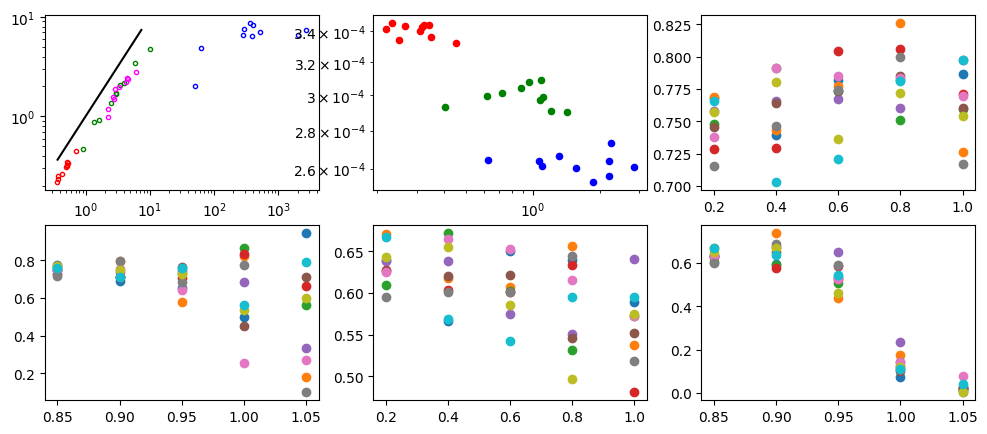

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(2,3,1)
tmp=var_FLR1_all[:10]
for inet in range(10):
    i=0
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="r",label="ipt=0.2 W0=0.85")
tmp=var_FLR1_all[40:50]
for inet in range(10):
    i=0
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="g",label="ipt=1 W0=0.85")

tmp=var_FLR1_all[70:80]
for inet in range(10):
    i=0
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="magenta",label="ipt=0.2 W0=1.05")

tmp=var_FLR1_all[90:100]
for inet in range(10):
    i=0
    plt.plot(np.sqrt(np.sum(tmp[inet][2][i]**2)),np.sqrt(np.sum(tmp[inet][1][i]**2)),markersize=3,marker="o",markerfacecolor='none', markeredgecolor="b",label="ipt=0.2 W0=1.05")
x=np.exp(np.linspace(-1,2,5))
plt.plot(x,x,c="k")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2,3,2)
tmp=var_FLR1_all[:10]
for inet in range(10):
  plt.scatter(np.sqrt(np.sum(tmp[inet][1][0]**2)),tmp[inet][3][0],s=20,c="r",label="ipt=0.2 W0=0.85")
tmp=var_FLR1_all[10:20]
for inet in range(10):
  plt.scatter(np.sqrt(np.sum(tmp[inet][1][0]**2)),tmp[inet][3][0],s=20,c="g",label="ipt=1 W0=0.85")
tmp=var_FLR1_all[20:30]
for inet in range(10):
  plt.scatter(np.sqrt(np.sum(tmp[inet][1][0]**2)),tmp[inet][3][0],s=20,c="b",label="ipt=0.2 W0=1")

plt.xscale("log")
plt.yscale("log")

plt.subplot(2,3,3)
for i in range(5):
  tmp=var_FLR1_all[10*i:10*(i+1)]
  for inet in range(10):
      plt.scatter(list_ipt[i],tmp[inet][0][0])
plt.subplot(2,3,4)
for i in range(5):
  tmp=var_FLR1_all[50+10*i:50+10*(i+1)]
  for inet in range(10):
      plt.scatter(list_W0[i],tmp[inet][0][0])

plt.subplot(2,3,5)
for i in range(5):
  tmp=var_FLR1_all[10*i:10*(i+1)]
  for inet in range(10):
      plt.scatter(list_ipt[i],np.sqrt(np.sum(tmp[inet][1][0]**2))/np.sqrt(np.sum(tmp[inet][2][0]**2)))

plt.subplot(2,3,6)
for i in range(5):
  tmp=var_FLR1_all[50+10*i:50+10*(i+1)]
  for inet in range(10):
      plt.scatter(list_W0[i],np.sqrt(np.sum(tmp[inet][1][0]**2))/np.sqrt(np.sum(tmp[inet][2][0]**2)))



plt.savefig(save_dir+"comp_FLR1_spd.eps")

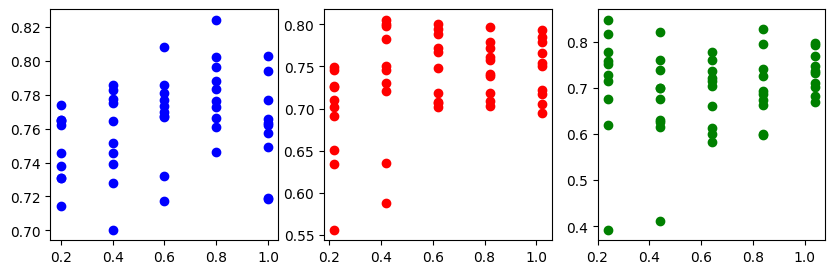

In [ ]:
plt.figure(figsize=(10,3))
tmp=var_FLR1_all[:50]
plt.subplot(1,3,1)
for i,ipt_str in enumerate(list_ipt):
  for inet in range(10):
    plt.scatter(ipt_str,tmp[i*10+inet][0],c="b",label="W0=0.85")

plt.subplot(1,3,2)
tmp=var_FLR1_all[50:100]
for i,ipt_str in enumerate(list_ipt):
  for inet in range(10):
    plt.scatter(ipt_str+0.02,tmp[i*10+inet][0],c="r",label="W0=0.95")

plt.subplot(1,3,3)
tmp=var_FLR1_all[100:]
for i,ipt_str in enumerate(list_ipt):
  for inet in range(10):
    plt.scatter(ipt_str+0.04,tmp[i*10+inet][0],c="g",label="W0=1.05")
plt.savefig(save_dir+"comp_FLR1_sim.eps")

### calc speed

In [ ]:
def gen_sim_FLR1():
    ##  calc the empirical speeds
    output_init,h_before = eval_with_W_hh(W_hh_before)
    output_after0,h_0 = eval_with_W_hh(W_hh_epoch0)
    dltx_emp=np.mean(h_0[-50:,:],axis=0)-np.mean(h_before[-50:,:],axis=0)

    noise_std = 0.1  # ノイズの標準偏差
    repeat = 10  # 例えば5回
    noisy_outputs, h_noisy = run_noisy_simulation(W_hh_before, x_input.repeat(1000, 1),noise_std=noise_std, repeat=repeat)
    cov_spn = np.mean(np.array([np.cov(h_noisy[i][10:].T) for i in range(repeat)]),axis=0)
    dltW=np.copy((W_hh_epoch0 - W_hh_before).detach().cpu().numpy())
    dltx_th=(beta/(noise_std**2))*cov_spn@dltW@np.mean(h_before[-50:,:],axis=0).reshape(-1,1)

    x,y=dltx_emp,dltx_th[:,0]
    sim=np.sum(x*y)/np.sqrt(np.sum(x**2)*np.sum(y**2))

    return sim

In [ ]:
## calc the theoretical speed
# --- ノイズありでシミュレーション ---
noise_std = 0.1  # ノイズの標準偏差
repeat = 10  # 例えば5回
noisy_outputs, h_noisy = run_noisy_simulation(W_hh_before, x_input.repeat(1000, 1),noise_std=noise_std, repeat=repeat)
cov_spn = np.mean(np.array([np.cov(h_noisy[i][10:].T) for i in range(repeat)]),axis=0)
dltW=np.copy((W_hh_epoch0 - W_hh_before).detach().cpu().numpy())
dltx_th=(beta/(noise_std**2))*cov_spn@dltW@h_before[-2:-1,:].T

In [ ]:
#plt.plot(dltx_emp)
#plt.plot(dltx_th[:,0])

x,y=dltx_emp,dltx_th[:,0]
sim=np.sum(x*y)/np.sqrt(np.sum(x**2)*np.sum(y**2))
print(sim)

0.7305674321387208


In [ ]:
##  inference phase
model.eval()
with torch.no_grad():
    output, h = model(x_input)

In [ ]:
output=output.detach().cpu().numpy()
h=h.detach().cpu().numpy()
Wout=model.W_out.detach().cpu().numpy()

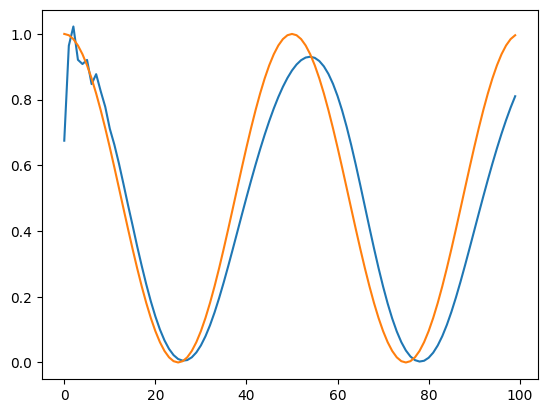

In [ ]:
plt.plot( (Wout@h.T).T )
plt.plot(target)

In [ ]:
h_noisy.shape

(1, 100, 200)

NameError: name 'h_before' is not defined

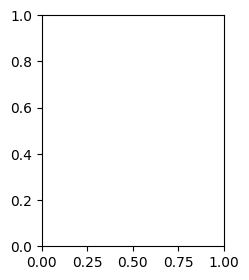

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
plt.plot(h_before[:,:5])
plt.subplot(1,3,2)
plt.plot(h_0[:,:5])
plt.subplot(1,3,3)
plt.plot(h[:,:5])